In [1]:
import os
import numpy as np 
from astropy import units as u
from astropy.cosmology import Planck13

In [2]:
import emcee

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read noiseless data

In [4]:
_mock = np.load('/Users/chahah/data/binsin/sample_UVLF_1pointingCEERS.npy')

In [6]:
# simple selection
select = ((_mock[:,0] > 8) & (_mock[:,0] < 10) & (_mock[:,1] < -15.5))
mock = _mock[select]

# indices = np.random.choice(np.arange(mock.shape[0])[mock[:,0] < 9.], size=int(mock.shape[0]/2), replace=False)
# indices = np.concatenate([indices, np.arange(mock.shape[0])[mock[:,0] >= 9.]])

# mock = mock[indices]

(-14.0, -22.0)

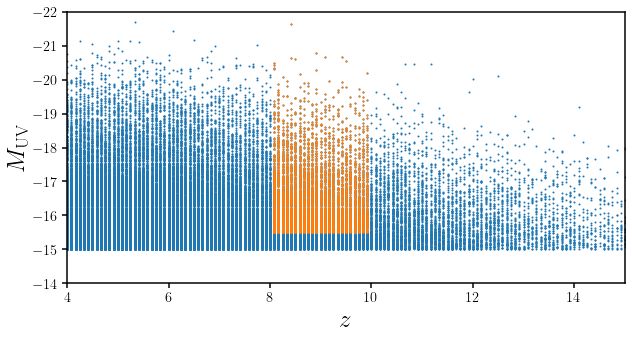

In [7]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(_mock[:,0], _mock[:,1], s=1)
sub.scatter(mock[:,0], mock[:,1], s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

In [8]:
n_mcmc = 100
posteriors = np.zeros((len(mock), 2, n_mcmc))
posteriors[:,0,:] = mock[:,0][:,None] + 0.01 * np.random.normal(size=(len(mock), n_mcmc))
posteriors[:,1,:] = mock[:,1][:,None] + 0.01 * np.random.normal(size=(len(mock), n_mcmc))

In [9]:
def LF(Muv, z, phi): 
    #Muv_s = -19.5
    alpha, beta, gamma, Muv_s = phi
    return (10**(gamma * (z - 9.)))/(10**(0.4*(alpha + 1)*(Muv - Muv_s) + 10**(0.4*(beta + 1)*(Muv - Muv_s))))

def Fselect(Muv, z): 
    S = np.ones(Muv.shape)
    #S[z < 9.0] = 0.5
    return S

In [10]:
unif = np.array([8., -22])[None,:] + np.array([2, 6.5])[None,:] * np.random.uniform(size=(10000, 2))

In [16]:
unif_S = Fselect(unif[:,1], unif[:,0])
mock_S = Fselect(mock[:,1], mock[:,0])
    
def log_prior(phi): 
    alpha, beta, gamma, Muv_s = phi
    if -3. < alpha < 1. and -3. < beta < 1. and -1. < gamma < 1 and -22 < Muv_s < -15: 
        return 0.
    return -np.inf

def log_posterior(phi): 
    lp = log_prior(phi)
    if not np.isfinite(lp):
        return -np.inf
    
    #Phi = LF(posteriors[:,1,:], posteriors[:,0,:], phi)
    Phi = LF(mock[:,1], mock[:,0], phi)
    norm_Phi = np.sum(LF(unif[:,1], unif[:,0], phi) * unif_S)
    Phi /= norm_Phi
    
    #logp = np.sum(np.log(np.sum(Phi, axis=1)), axis=0)
    logp = np.sum(np.log(Phi / mock_S))
    if np.isnan(logp): raise ValueError
    return logp

In [17]:
log_posterior([-1.5,  -1.33, -0.2, -17.98954929]), log_posterior([-1.21126749, -1.39672104, -0.14763412, -19.5]), log_posterior([-0.001, -1.45, -0.05, -20]), log_posterior([-2.99, -2.8, -0.98, -19])

(-53125.76046950639,
 -53625.775010835634,
 -65332.81178602655,
 -59120.0432295024)

In [18]:
ndim, nwalkers = 4, 20
var = np.array([0.1, 0.1, 0.1, 0.1])
p0 = np.array([-1.2, -1.4, -0.15, -19.4])[None,:] + var[None,:]*np.random.randn(nwalkers, ndim)

In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
_ = sampler.run_mcmc(p0, 1000, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:22<00:00, 44.68it/s]


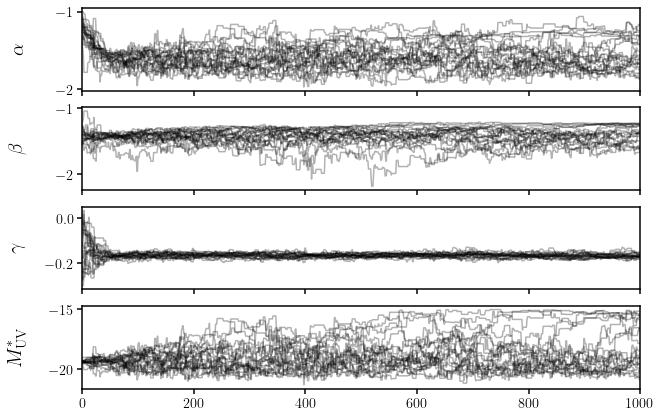

In [20]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel([r'$\alpha$', r'$\beta$', r'$\gamma$', r'$M_{\rm UV}^*$'][i], fontsize=20)
    ax.yaxis.set_label_coords(-0.1, 0.5)

In [21]:
from binsin import lf as bLF

/Users/chahah/projects/packages/zeus21/zeus21/UVLFs.py:27: RuntimeWarning: divide by zero encountered in log10
  MUVtab = 51.63 - 2.5 * np.log10(LUVtab) #AB magnitude


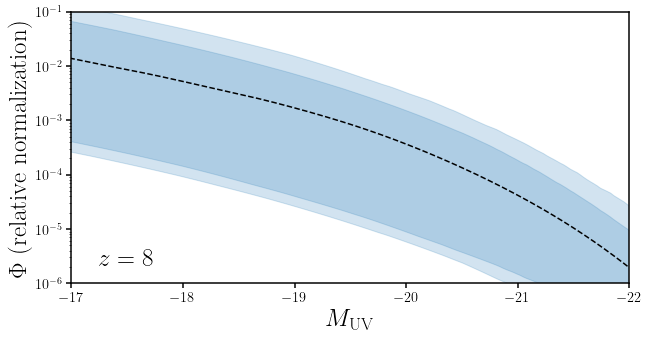

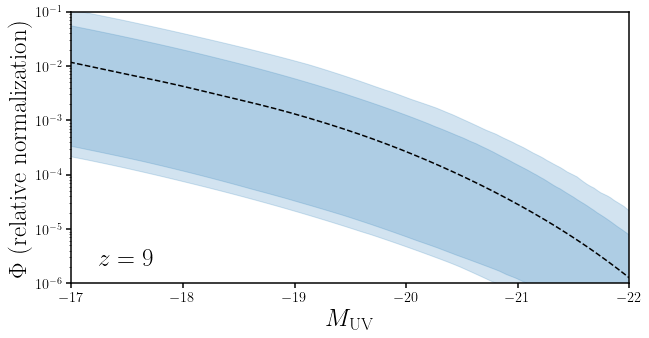

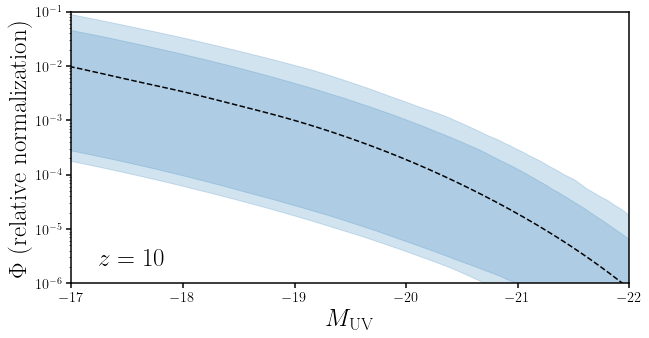

In [22]:
for z in [8.5, 9, 9.5]: 
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)

    muv, lf = bLF.lf_zeus21(z)
    
    lfs = []
    for phi in sampler.flatchain[nwalkers*-200:,:]:
        lfs.append(LF(muv, z, phi))

    phi_med = np.median(sampler.flatchain[nwalkers*-100:,:], axis=0)
    
    #norm = np.sum(LF(unif[:,1], unif[:,0], phi_med) * unif_S)
    #f = lambda y, x: LF(x, y, phi_med) * p_theta_S(x, y)
    #norm = integrate.dblquad(f, -22, -16, 4, 15)
    #print(1/(float(len(mock_Muv))/norm))

    q0, q1, q2, q3 = np.quantile(1e-2*np.array(lfs), [0.025, 0.16, 0.84, 0.975], axis=0)

    sub.fill_between(muv, q0, q3, color='C0', alpha=0.2)
    sub.fill_between(muv, q1, q2, color='C0', alpha=0.2)
    sub.plot(muv, lf, c='k', ls='--')
    
    sub.text(0.05, 0.05, r'$z=%.f$' % z, fontsize=25, transform=sub.transAxes, ha='left', va='bottom')
    sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
    sub.set_xlim(-17, -22)
    sub.set_ylabel(r'$\Phi$ (relative normalization)', fontsize=25)
    sub.set_yscale('log')
    sub.set_ylim(1e-6, 1e-1)#sub.set_ylim(0.1, 4e2)
    #sub.set_ylim(0.1, 4e2)